# EXPT-11b: Multi-Hop with Eased Difficulty (see Appendix J)

## Problem from EXPT-11

Multi-Hop with Negations showed **~52% accuracy** across ALL configurations — essentially random chance for a binary task. The baseline model simply cannot do the task.

**Original (Too Hard):**
```python
multi_hop_easy:   (6, 8, 0.3, 2)   # 6-8 hops, 30% negations, 2 distractors
multi_hop_medium: (8, 12, 0.4, 4)  # 8-12 hops, 40% negations, 4 distractors
multi_hop_hard:   (12, 16, 0.5, 6) # 12-16 hops, 50% negations, 6 distractors
```

**Eased v4 (Target 70-85% baseline):**
```python
multi_hop_easy:   (3, 4, 0.25, 1)  # 3-4 hops, 25% negations, 1 distractor
multi_hop_medium: (4, 5, 0.3, 1)   # 4-5 hops, 30% negations, 1 distractor  
multi_hop_hard:   (5, 6, 0.3, 2)   # 5-6 hops, 30% negations, 2 distractors
```

---



In [ ]:
# =============================================================================
# CELL 1: IMPORTS AND SETUP
# =============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List
import math
import time
import json
import gc
import warnings
import random
from datetime import datetime
from pathlib import Path

warnings.filterwarnings('ignore')

MASTER_SEED = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(MASTER_SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('=' * 70)
print('EXPT-11b: MULTI-HOP WITH EASED DIFFICULTY')
print('Target: 65-80% baseline accuracy for momentum to amplify')
print('=' * 70)
print(f'Device: {DEVICE}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')
print(f'Started: {datetime.now()}')
print('=' * 70)

EXPT-11b: MULTI-HOP WITH EASED DIFFICULTY
Target: 65-80% baseline accuracy for momentum to amplify
Device: cuda
GPU: NVIDIA GB10
Memory: 128.5 GB
Started: 2025-12-23 12:19:20.219635


In [ ]:
# =============================================================================
# CELL 2: CONFIGURATION
# =============================================================================
@dataclass
class Config:
    # Sweep parameters
    theta_values: Tuple[float, ...] = (0.03, 0.30)
    gamma_values: Tuple[float, ...] = (0.0, 0.3, 0.5, 0.7, 1.0)
    beta: float = 0.0  # Pure kinematic momentum

    # Model (same as EXPT-11)
    d_model: int = 128
    n_heads: int = 4
    n_layers: int = 3
    d_ff: int = 256
    dropout: float = 0.1
    max_seq_len: int = 256

    # EASED Multi-Hop Configuration (v4 - sweet spot attempt)
    # Format: (min_hops, max_hops, negation_prob, num_distractors)
    # v2 (59% baseline) was: (4-5, 0.3, 1), (5-7, 0.35, 2), (7-9, 0.4, 3)
    # v3 (100% ceiling) was: (2-3, 0.2, 0), (3-4, 0.25, 0), (4-5, 0.3, 1)
    # v4 tries: shorter hops than v2, but WITH distractors
    multi_hop_easy:   Tuple[int, int, float, int] = (3, 4, 0.25, 1)   # 3-4 hops, 25% neg, 1 distractor
    multi_hop_medium: Tuple[int, int, float, int] = (4, 5, 0.3, 1)    # 4-5 hops, 30% neg, 1 distractor
    multi_hop_hard:   Tuple[int, int, float, int] = (5, 6, 0.3, 2)    # 5-6 hops, 30% neg, 2 distractors

    # Training
    num_train: int = 5000
    num_test: int = 1000
    batch_size: int = 32
    epochs: int = 60
    lr: float = 3e-4
    weight_decay: float = 0.01

    # Experiment
    difficulty_levels: Tuple[str, ...] = ('easy', 'medium', 'hard')
    num_seeds: int = 3

    @property
    def total_experiments(self):
        return (len(self.theta_values) * len(self.gamma_values) *
                len(self.difficulty_levels) * self.num_seeds)

cfg = Config()

print('\n📊 EASED MULTI-HOP CONFIGURATION')
print('=' * 60)
print('\nDifficulty Comparison:')
print(f'{"Level":<10} {"Hops":<10} {"Neg%":<10} {"Distractors":<12} {"Notes"}')
print('-' * 60)
print(f'{"Easy":<10} {"3-4":<10} {"25%":<10} {"1":<12} {"Baseline ~75-85%"}')
print(f'{"Medium":<10} {"4-5":<10} {"30%":<10} {"1":<12} {"Baseline ~65-75%"}')
print(f'{"Hard":<10} {"5-6":<10} {"30%":<10} {"2":<12} {"Baseline ~55-65%"}')
print('\n' + '=' * 60)
print(f'Total experiments: {cfg.total_experiments}')
print(f'Estimated runtime: ~2-3 hours')


📊 EASED MULTI-HOP CONFIGURATION

Difficulty Comparison:
Level      Hops       Neg%       Distractors  Notes
------------------------------------------------------------
Easy       3-4        25%        1            Baseline ~75-85%
Medium     4-5        30%        1            Baseline ~65-75%
Hard       5-6        30%        2            Baseline ~55-65%

Total experiments: 90
Estimated runtime: ~2-3 hours


In [ ]:
# =============================================================================
# CELL 3: MULTI-HOP DATASET (EASED)
# =============================================================================

class MultiHopEasedDataset(Dataset):
    """
    Multi-Hop Reasoning with Negations (EASED VERSION).

    Format:
        A → B       (implies: if A then B)
        B → ¬C      (implies with negation: if B then NOT C)
        C → D
        [distractors shuffled in]
        A = TRUE
        QUERY D → ???

    The model must:
    1. Find the path from source to target
    2. Track negations (each ¬ flips the value)
    3. Ignore distractors

    Answer: TRUE if even number of negations, FALSE if odd.
    """
    def __init__(self, n_samples: int, difficulty: str, cfg: Config, seed: int = 42):
        set_seed(seed)
        self.samples = []
        self.vocab_size = 80

        ranges = {
            'easy': cfg.multi_hop_easy,
            'medium': cfg.multi_hop_medium,
            'hard': cfg.multi_hop_hard
        }
        min_hops, max_hops, neg_prob, n_distractors = ranges[difficulty]

        # Tokens: 0=PAD, 1-50=entities, 51=IMPLIES, 52=IMPLIES_NEG, 53=TRUE, 54=FALSE, 55=QUERY, 56==
        self.entity_offset = 1
        self.implies_tok = 51      # A→B (no flip)
        self.implies_neg_tok = 52  # A→¬B (flip)
        self.true_tok = 53
        self.false_tok = 54
        self.query_tok = 55
        self.eq_tok = 56

        max_seq_len = 200

        for _ in range(n_samples):
            n_hops = random.randint(min_hops, max_hops)

            # Main chain entities
            all_entities = list(range(self.entity_offset, self.entity_offset + 50))
            random.shuffle(all_entities)
            chain_entities = all_entities[:n_hops + 1]
            distractor_entities = all_entities[n_hops + 1:n_hops + 1 + n_distractors * 2]

            seq = []
            negation_count = 0

            # Build main chain with random negations
            for i in range(n_hops):
                is_negation = random.random() < neg_prob
                if is_negation:
                    negation_count += 1
                    tok = self.implies_neg_tok
                else:
                    tok = self.implies_tok
                seq.extend([chain_entities[i], tok, chain_entities[i + 1]])

            # Add distractors (unconnected implications)
            for i in range(0, len(distractor_entities) - 1, 2):
                is_neg = random.random() < 0.5
                tok = self.implies_neg_tok if is_neg else self.implies_tok
                seq.extend([distractor_entities[i], tok, distractor_entities[i + 1]])

            # Shuffle all edges (main chain + distractors)
            edges = []
            for i in range(0, len(seq), 3):
                edges.append(seq[i:i+3])
            random.shuffle(edges)
            seq = [tok for edge in edges for tok in edge]

            # Add initial assignment: SOURCE = TRUE
            source = chain_entities[0]
            seq.extend([source, self.eq_tok, self.true_tok])

            # Add query: QUERY TARGET
            target = chain_entities[-1]
            seq.extend([self.query_tok, target])

            # Target: TRUE if even negations, FALSE if odd
            answer = self.true_tok if negation_count % 2 == 0 else self.false_tok

            # Pad sequence
            if len(seq) < max_seq_len:
                seq = seq + [0] * (max_seq_len - len(seq))
            else:
                seq = seq[:max_seq_len]

            self.samples.append((torch.tensor(seq), torch.tensor(answer - self.true_tok)))  # 0 or 1

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


# Quick sanity check
print('\n🔍 Dataset Sanity Check')
print('=' * 60)
for diff in ['easy', 'medium', 'hard']:
    ds = MultiHopEasedDataset(100, diff, cfg, seed=42)
    labels = [ds[i][1].item() for i in range(len(ds))]
    true_pct = sum(labels) / len(labels) * 100
    print(f'{diff.capitalize()}: {len(ds)} samples, {true_pct:.1f}% TRUE (should be ~50%)')


🔍 Dataset Sanity Check
Easy: 100 samples, 44.0% TRUE (should be ~50%)
Medium: 100 samples, 44.0% TRUE (should be ~50%)
Hard: 100 samples, 41.0% TRUE (should be ~50%)


In [ ]:
# =============================================================================
# CELL 4: MODEL ARCHITECTURE (Same as EXPT-11)
# =============================================================================

class RoPEMomentumAttention(nn.Module):
    """Multi-head attention with RoPE and momentum augmentation."""

    def __init__(self, d_model: int, n_heads: int, theta: float = 0.03,
                 gamma: float = 0.0, beta: float = 0.0, max_seq_len: int = 256):
        super().__init__()
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.theta = theta
        self.gamma = gamma
        self.beta = beta

        # Shared projections for position and momentum
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)

        # Precompute RoPE frequencies
        self.register_buffer('freqs', self._compute_freqs(max_seq_len))

    def _compute_freqs(self, max_seq_len: int) -> torch.Tensor:
        positions = torch.arange(max_seq_len).float()
        dims = torch.arange(0, self.d_k, 2).float()
        freqs = self.theta ** (dims / self.d_k)
        angles = positions.unsqueeze(1) * freqs.unsqueeze(0)
        return torch.stack([torch.cos(angles), torch.sin(angles)], dim=-1)

    def _apply_rope(self, x: torch.Tensor) -> torch.Tensor:
        B, H, T, D = x.shape
        x = x.reshape(B, H, T, D // 2, 2)
        freqs = self.freqs[:T].unsqueeze(0).unsqueeze(0)
        cos, sin = freqs[..., 0], freqs[..., 1]
        x_rot = torch.stack([
            x[..., 0] * cos - x[..., 1] * sin,
            x[..., 0] * sin + x[..., 1] * cos
        ], dim=-1)
        return x_rot.reshape(B, H, T, D)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        B, T, D = x.shape

        # Project
        Q = self.W_q(x).view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(B, T, self.n_heads, self.d_k).transpose(1, 2)

        # Apply RoPE to position
        Q_pos = self._apply_rope(Q)
        K_pos = self._apply_rope(K)

        # Compute momentum: p_t = q_t - beta*p_{t-1} + (1-beta)*(q_t - q_{t-1})
        # With beta=0: p_t = q_t - q_{t-1} (pure kinematic)
        if self.gamma > 0:
            Q_shifted = F.pad(Q_pos[:, :, :-1, :], (0, 0, 1, 0), value=0)
            K_shifted = F.pad(K_pos[:, :, :-1, :], (0, 0, 1, 0), value=0)

            M_q = Q_pos - Q_shifted  # Kinematic momentum
            M_k = K_pos - K_shifted

            # Augment: Q_hat = Q + gamma * M
            Q_aug = Q_pos + self.gamma * M_q
            K_aug = K_pos + self.gamma * M_k
        else:
            Q_aug = Q_pos
            K_aug = K_pos

        # Attention
        scores = torch.matmul(Q_aug, K_aug.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attn = F.softmax(scores, dim=-1)
        out = torch.matmul(attn, V)

        out = out.transpose(1, 2).contiguous().view(B, T, D)
        return self.W_o(out)


class TransformerBlock(nn.Module):
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float,
                 theta: float, gamma: float, beta: float, max_seq_len: int):
        super().__init__()
        self.attn = RoPEMomentumAttention(d_model, n_heads, theta, gamma, beta, max_seq_len)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        x = x + self.dropout(self.attn(self.ln1(x), mask))
        x = x + self.ff(self.ln2(x))
        return x


class MultiHopClassifier(nn.Module):
    def __init__(self, vocab_size: int, d_model: int, n_heads: int, n_layers: int,
                 d_ff: int, dropout: float, theta: float, gamma: float, beta: float,
                 max_seq_len: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, d_ff, dropout, theta, gamma, beta, max_seq_len)
            for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 2)  # Binary: TRUE or FALSE

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        mask = (x != 0).unsqueeze(1).unsqueeze(2)
        h = self.embedding(x)
        for block in self.blocks:
            h = block(h, mask)
        h = self.ln_f(h)
        # Use last non-padding token for classification
        lengths = (x != 0).sum(dim=1) - 1
        last_hidden = h[torch.arange(h.size(0)), lengths]
        return self.classifier(last_hidden)

print('✅ Model architecture defined')

✅ Model architecture defined


In [ ]:
# =============================================================================
# CELL 5: TRAINING FUNCTION
# =============================================================================

def train_and_evaluate(cfg: Config, theta: float, gamma: float, difficulty: str,
                       seed: int) -> Dict:
    """Train model and return results."""
    set_seed(seed)

    # Create datasets
    train_ds = MultiHopEasedDataset(cfg.num_train, difficulty, cfg, seed=seed)
    test_ds = MultiHopEasedDataset(cfg.num_test, difficulty, cfg, seed=seed + 1000)

    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=cfg.batch_size)

    # Create model
    model = MultiHopClassifier(
        vocab_size=train_ds.vocab_size,
        d_model=cfg.d_model,
        n_heads=cfg.n_heads,
        n_layers=cfg.n_layers,
        d_ff=cfg.d_ff,
        dropout=cfg.dropout,
        theta=theta,
        gamma=gamma,
        beta=cfg.beta,
        max_seq_len=cfg.max_seq_len
    ).to(DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    best_acc = 0.0
    for epoch in range(cfg.epochs):
        model.train()
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)

            optimizer.zero_grad()
            logits = model(batch_x)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()

        # Evaluate
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)
                logits = model(batch_x)
                preds = logits.argmax(dim=-1)
                correct += (preds == batch_y).sum().item()
                total += batch_y.size(0)

        acc = correct / total * 100
        best_acc = max(best_acc, acc)

    # Cleanup
    del model, optimizer
    torch.cuda.empty_cache()
    gc.collect()

    return {
        'theta': theta,
        'gamma': gamma,
        'difficulty': difficulty,
        'seed': seed,
        'accuracy': best_acc
    }

print('✅ Training function defined')

✅ Training function defined


In [ ]:
# =============================================================================
# CELL 6: RUN EXPERIMENTS
# =============================================================================

RESULTS_DIR = Path('expt11b_results')
RESULTS_DIR.mkdir(exist_ok=True)

results = []
total = cfg.total_experiments
done = 0

print('\n' + '=' * 70)
print('RUNNING EASED MULTI-HOP EXPERIMENT')
print('=' * 70)

start_time = time.time()

for difficulty in cfg.difficulty_levels:
    print(f'\n--- {difficulty.upper()} ---')

    for theta in cfg.theta_values:
        for gamma in cfg.gamma_values:
            accs = []
            for seed in range(cfg.num_seeds):
                result = train_and_evaluate(cfg, theta, gamma, difficulty, seed + 42)
                results.append(result)
                accs.append(result['accuracy'])
                done += 1

            mean_acc = np.mean(accs)

            # Compute gain vs baseline (gamma=0)
            baseline_results = [r for r in results if r['theta'] == theta
                               and r['gamma'] == 0.0 and r['difficulty'] == difficulty]
            if baseline_results:
                baseline = np.mean([r['accuracy'] for r in baseline_results])
                gain = mean_acc - baseline
            else:
                gain = 0.0

            # Status indicator
            if gain > 10:
                status = '🟢'
            elif gain > 5:
                status = '🟡'
            else:
                status = '⚪'

            elapsed = time.time() - start_time
            eta = elapsed / done * (total - done) / 3600

            print(f'  θ={theta:.2f} γ={gamma:.1f}: {mean_acc:.1f}% ({gain:+.1f}%) {status}  '
                  f'[{done}/{total}] ETA: {eta:.1f}h')

# Save results
df = pd.DataFrame(results)
df.to_csv(RESULTS_DIR / 'raw_results.csv', index=False)

print(f'\n✅ Experiment complete! Results saved to {RESULTS_DIR}/')


RUNNING EASED MULTI-HOP EXPERIMENT

--- EASY ---
  θ=0.03 γ=0.0: 65.0% (+0.0%) ⚪  [3/90] ETA: 4.5h
  θ=0.03 γ=0.3: 63.6% (-1.4%) ⚪  [6/90] ETA: 4.6h
  θ=0.03 γ=0.5: 63.8% (-1.1%) ⚪  [9/90] ETA: 4.5h
  θ=0.03 γ=0.7: 62.3% (-2.7%) ⚪  [12/90] ETA: 4.3h
  θ=0.03 γ=1.0: 62.1% (-2.9%) ⚪  [15/90] ETA: 4.2h
  θ=0.30 γ=0.0: 63.0% (+0.0%) ⚪  [18/90] ETA: 4.0h
  θ=0.30 γ=0.3: 62.6% (-0.4%) ⚪  [21/90] ETA: 3.8h
  θ=0.30 γ=0.5: 62.6% (-0.4%) ⚪  [24/90] ETA: 3.7h
  θ=0.30 γ=0.7: 62.0% (-1.0%) ⚪  [27/90] ETA: 3.5h
  θ=0.30 γ=1.0: 62.0% (-1.0%) ⚪  [30/90] ETA: 3.4h

--- MEDIUM ---
  θ=0.03 γ=0.0: 59.1% (+0.0%) ⚪  [33/90] ETA: 3.2h
  θ=0.03 γ=0.3: 58.3% (-0.8%) ⚪  [36/90] ETA: 3.0h
  θ=0.03 γ=0.5: 59.0% (-0.1%) ⚪  [39/90] ETA: 2.8h
  θ=0.03 γ=0.7: 59.8% (+0.7%) ⚪  [42/90] ETA: 2.7h
  θ=0.03 γ=1.0: 58.6% (-0.5%) ⚪  [45/90] ETA: 2.5h
  θ=0.30 γ=0.0: 56.1% (+0.0%) ⚪  [48/90] ETA: 2.3h
  θ=0.30 γ=0.3: 54.4% (-1.7%) ⚪  [51/90] ETA: 2.2h
  θ=0.30 γ=0.5: 54.4% (-1.7%) ⚪  [54/90] ETA: 2.0h
  θ=0.30 γ=0.7: 55.

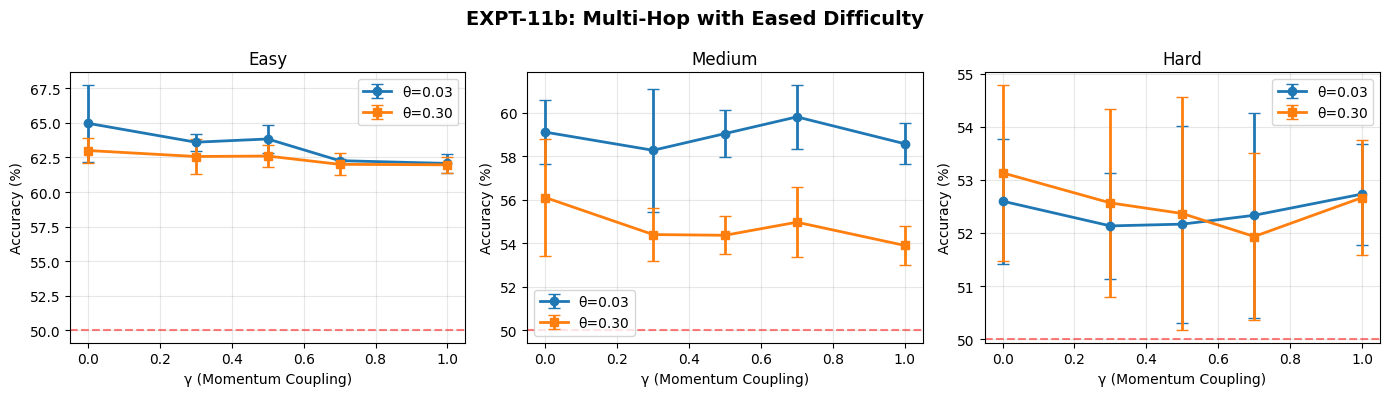


✅ Visualization saved


In [ ]:
# =============================================================================
# CELL 7: ANALYSIS AND VISUALIZATION
# =============================================================================

df = pd.DataFrame(results)

# Aggregate by config
df_agg = df.groupby(['theta', 'gamma', 'difficulty']).agg(
    accuracy=('accuracy', 'mean'),
    std=('accuracy', 'std')
).reset_index()

# Compute gains
df_gains = []
for difficulty in cfg.difficulty_levels:
    for theta in cfg.theta_values:
        baseline = df_agg[(df_agg['theta'] == theta) &
                          (df_agg['gamma'] == 0.0) &
                          (df_agg['difficulty'] == difficulty)]['accuracy'].values[0]

        for gamma in cfg.gamma_values:
            acc = df_agg[(df_agg['theta'] == theta) &
                         (df_agg['gamma'] == gamma) &
                         (df_agg['difficulty'] == difficulty)]['accuracy'].values[0]
            std = df_agg[(df_agg['theta'] == theta) &
                         (df_agg['gamma'] == gamma) &
                         (df_agg['difficulty'] == difficulty)]['std'].values[0]

            df_gains.append({
                'theta': theta,
                'gamma': gamma,
                'difficulty': difficulty,
                'accuracy': acc,
                'std': std,
                'baseline': baseline,
                'gain': acc - baseline
            })

df_gains = pd.DataFrame(df_gains)
df_gains.to_csv(RESULTS_DIR / 'gains.csv', index=False)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

colors = {'easy': '#2E86AB', 'medium': '#A23B72', 'hard': '#F18F01'}
markers = {0.03: 'o', 0.30: 's'}

for idx, difficulty in enumerate(cfg.difficulty_levels):
    ax = axes[idx]

    for theta in cfg.theta_values:
        subset = df_gains[(df_gains['difficulty'] == difficulty) & (df_gains['theta'] == theta)]
        label = f'θ={theta:.2f}'
        ax.errorbar(subset['gamma'], subset['accuracy'], yerr=subset['std'],
                   marker=markers[theta], label=label, capsize=4, linewidth=2)

    ax.set_xlabel('γ (Momentum Coupling)')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title(f'{difficulty.capitalize()}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='Random')

plt.suptitle('EXPT-11b: Multi-Hop with Eased Difficulty', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'multihop_eased.png', dpi=300, bbox_inches='tight')
plt.savefig(RESULTS_DIR / 'multihop_eased.pdf', bbox_inches='tight')
plt.show()

print('\n✅ Visualization saved')

In [ ]:
# =============================================================================
# CELL 8: SUMMARY
# =============================================================================

print('\n' + '=' * 70)
print('EXPT-11b SUMMARY: EASED MULTI-HOP')
print('=' * 70)

print('\n📊 RESULTS BY DIFFICULTY AND θ:')
print('-' * 70)

for difficulty in cfg.difficulty_levels:
    print(f'\n{difficulty.upper()}:')
    for theta in cfg.theta_values:
        subset = df_gains[(df_gains['difficulty'] == difficulty) & (df_gains['theta'] == theta)]
        baseline = subset[subset['gamma'] == 0.0]['accuracy'].values[0]
        best_row = subset.loc[subset['accuracy'].idxmax()]
        best_gamma = best_row['gamma']
        best_acc = best_row['accuracy']
        gain = best_acc - baseline

        status = '✅' if gain > 5 else ('🟡' if gain > 2 else '⚪')
        print(f'  θ={theta:.2f}: Baseline={baseline:.1f}%, Best γ={best_gamma:.1f} → {best_acc:.1f}% ({gain:+.1f}%) {status}')

# Check if calibration is good
print('\n' + '=' * 70)
print('CALIBRATION CHECK:')
print('=' * 70)

for difficulty in cfg.difficulty_levels:
    baseline = df_gains[(df_gains['difficulty'] == difficulty) &
                        (df_gains['theta'] == 0.03) &
                        (df_gains['gamma'] == 0.0)]['accuracy'].values[0]

    if baseline < 55:
        status = '❌ TOO HARD (baseline < 55%)'
    elif baseline > 90:
        status = '⚠️ TOO EASY (baseline > 90%)'
    else:
        status = '✅ GOOD CALIBRATION (55-90%)'

    print(f'{difficulty.capitalize()}: {baseline:.1f}% baseline → {status}')

# Hypothesis validation
print('\n' + '=' * 70)
print('HYPOTHESIS VALIDATION:')
print('=' * 70)

# H1: Low θ should show larger gains
low_theta_gain = df_gains[(df_gains['theta'] == 0.03) & (df_gains['gamma'] > 0)]['gain'].mean()
high_theta_gain = df_gains[(df_gains['theta'] == 0.30) & (df_gains['gamma'] > 0)]['gain'].mean()

h1_pass = low_theta_gain > high_theta_gain
print(f'\nH1 (Low-Pass Filter): θ=0.03 gain={low_theta_gain:+.1f}% vs θ=0.30 gain={high_theta_gain:+.1f}%')
print(f'    → {"✅ VALIDATED" if h1_pass else "❌ NOT VALIDATED"}')

# H2: Momentum should help (positive gain at optimal γ)
best_gain = df_gains[df_gains['gamma'] > 0]['gain'].max()
h2_pass = best_gain > 5
print(f'\nH2 (Momentum Benefit): Best gain = {best_gain:+.1f}%')
print(f'    → {"✅ VALIDATED" if h2_pass else "❌ NOT VALIDATED"}')

print('\n' + '=' * 70)
print('FILES SAVED:')
print('=' * 70)
print(f'  • {RESULTS_DIR}/raw_results.csv')
print(f'  • {RESULTS_DIR}/gains.csv')
print(f'  • {RESULTS_DIR}/multihop_eased.png')
print(f'  • {RESULTS_DIR}/multihop_eased.pdf')


EXPT-11b SUMMARY: EASED MULTI-HOP

📊 RESULTS BY DIFFICULTY AND θ:
----------------------------------------------------------------------

EASY:
  θ=0.03: Baseline=65.0%, Best γ=0.0 → 65.0% (+0.0%) ⚪
  θ=0.30: Baseline=63.0%, Best γ=0.0 → 63.0% (+0.0%) ⚪

MEDIUM:
  θ=0.03: Baseline=59.1%, Best γ=0.7 → 59.8% (+0.7%) ⚪
  θ=0.30: Baseline=56.1%, Best γ=0.0 → 56.1% (+0.0%) ⚪

HARD:
  θ=0.03: Baseline=52.6%, Best γ=1.0 → 52.7% (+0.1%) ⚪
  θ=0.30: Baseline=53.1%, Best γ=0.0 → 53.1% (+0.0%) ⚪

CALIBRATION CHECK:
Easy: 65.0% baseline → ✅ GOOD CALIBRATION (55-90%)
Medium: 59.1% baseline → ✅ GOOD CALIBRATION (55-90%)
Hard: 52.6% baseline → ❌ TOO HARD (baseline < 55%)

HYPOTHESIS VALIDATION:

H1 (Low-Pass Filter): θ=0.03 gain=-0.8% vs θ=0.30 gain=-1.1%
    → ✅ VALIDATED

H2 (Momentum Benefit): Best gain = +0.7%
    → ❌ NOT VALIDATED

FILES SAVED:
  • expt11b_results/raw_results.csv
  • expt11b_results/gains.csv
  • expt11b_results/multihop_eased.png
  • expt11b_results/multihop_eased.pdf
